<a href="https://colab.research.google.com/github/jash-ai/PYTHON/blob/main/pytorch_3d_printer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Basic Neural Network with PyTorch

### Objective
In this exercise, we’ll build a simple neural network using PyTorch to predict **tensile strength** from various 3D printing parameters. This exercise will cover:
- Data preprocessing and splitting
- Defining a neural network architecture in PyTorch
- Training and evaluating the model
- Visualizing the training progress


### Step 1: Load and Inspect Data

In [1]:
##https://www.youtube.com/live/tRnIJi9MMRY
import pandas as pd

# Load the dataset
url = "https://raw.githubusercontent.com/beginners-machine-learning-london/intro_to_machine_learning_with_pytorch/refs/heads/master/assets/3dprinter.csv"
data = pd.read_csv(url)

# Display the first few rows
data.head()


,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,tension_strenght,elongation,roughness
0,0.02,8.0,90.0,grid,220.0,60.0,40.0,abs,0.0,18.0,1.2,25.0
1,0.02,7.0,90.0,honeycomb,225.0,65.0,40.0,abs,25.0,16.0,1.4,32.0
2,0.02,1.0,80.0,grid,230.0,70.0,40.0,abs,50.0,8.0,0.8,40.0
3,0.02,4.0,70.0,honeycomb,240.0,75.0,40.0,abs,75.0,10.0,0.5,68.0
4,0.02,6.0,90.0,grid,250.0,80.0,40.0,abs,100.0,5.0,0.7,92.0


### Step 2: Data Preprocessing

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset

data = data.dropna()
# Separate features and target (roughness)
X = data.drop(columns=["roughness"]) ##features
y = data["roughness"] ##target

# Encode categorical features assigns 1 and 0 replace text value to numbers
X = X.apply(lambda col: LabelEncoder().fit_transform(col) if col.dtype == "object" else col)

# Standardize the features
## those which has numbers in it will scale them between 0 to 1 help with training process
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors with the float32 data type
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Split data into training and test sets with a 80-20 split
## 20 % testing model not seen this data
## and 80% training
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create data loaders with 32 samples per batch. Shuffle the training set
# batch of rows using dataloader iternate the datasets to get sample of rows to pass to the mode
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=True)

In [12]:
X_scaled

array([[-1.42132749,  1.01003458,  1.51573398, -1.01835015, -0.03128056,
        -1.41421356, -0.75592895, -1.09544512, -0.91717274, -0.29866137,
        -0.63147707],
       [-1.42132749,  0.65163521,  1.51573398,  0.98198051,  0.31280562,
        -0.70710678, -0.75592895, -1.09544512, -0.51451868, -0.51914963,
        -0.41840199],
       [-1.42132749, -1.49876099,  1.10708021, -1.01835015,  0.65689181,
         0.        , -0.75592895, -1.09544512, -0.11186462, -1.40110267,
        -1.05762724],
       [-1.42132749, -0.42356289,  0.69842644,  0.98198051,  1.34506418,
         0.70710678, -0.75592895, -1.09544512,  0.29078944, -1.18061441,
        -1.37723987],
       [-1.42132749,  0.29323585,  1.51573398, -1.01835015,  2.03323655,
         1.41421356, -0.75592895, -1.09544512,  0.6934435 , -1.73183507,
        -1.16416479],
       [-1.42132749,  1.72683331, -0.52753486,  0.98198051, -1.40762531,
        -1.41421356, -0.75592895,  0.91287093, -0.91717274,  0.36280341,
        -0.738

### Step 3: Define the Neural Network Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# Define a basic neural network model
# Architecture: 3 fully connected layers with ReLU activation
# Input size: Number of features in the dataset
# Hidden Layers: 64, 32 neurons respectively with ReLU activation function
# Output size: 1 (roughness)
# specify class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32) #node 1 = 64, node 2 = 32
        self.fc3 = nn.Linear(32, 1) #output of 1 node

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x ##passes data to the neural network

# Initialize the model
model = NeuralNetwork(input_size=X_train.shape[1])
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=11, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


### Step 4: Set Up the Training Process

In [6]:
import torch.optim as optim

# Define loss function and optimizer for the neural network
# Select Mean Squared Error Loss and Adam optimizer with a learning rate of 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Step 5: Train the Neural Network

In [7]:
# Training parameters
##against the training dataset
num_epochs = 100
train_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)##prediction to actuals and get you loss different

        # Backward pass and optimization
        loss.backward() ##calculate adjustments
        optimizer.step() ##perform the adjustments

        running_loss += loss.item()

    # Average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training complete.") ##going to 100 epoch printing at every 10

Epoch [10/100], Loss: 36050.9033
Epoch [20/100], Loss: 34341.4775
Epoch [30/100], Loss: 32610.7236
Epoch [40/100], Loss: 37785.1895
Epoch [50/100], Loss: 31683.1123
Epoch [60/100], Loss: 30330.4463
Epoch [70/100], Loss: 25700.4600
Epoch [80/100], Loss: 18075.1060
Epoch [90/100], Loss: 12370.7842
Epoch [100/100], Loss: 10087.6890
Training complete.


### Step 6: Evaluate the Model

In [8]:
model.eval()
test_loss = 0.0
##against the test dataset

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

test_loss /= len(test_loader)##average test loss
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 17642.0234


### Step 7: Visualize Training Loss

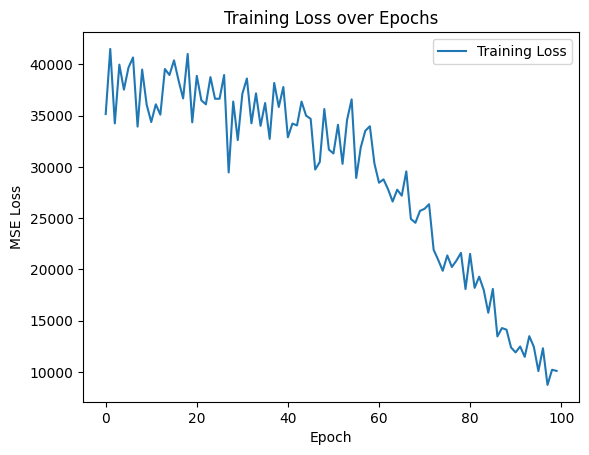

In [9]:
import matplotlib.pyplot as plt

# Plot training loss over epochs
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss") #mean square error loss
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

### Step 8: Evaluate Model

In [10]:
# Ensure the model is in evaluation mode
model.eval()

# Convert the entire dataset (X_scaled) to a PyTorch tensor
X_full_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# Get predictions on the full dataset
with torch.no_grad():
    predictions_full = model(X_full_tensor).squeeze().tolist()

# Add predictions and calculate squared error (MSE) for each prediction
data = data.dropna()
data["Predicted_roughness"] = predictions_full ##new column
data["Squared_Error"] = (data["roughness"] - data["Predicted_roughness"]) ** 2

# Display the final DataFrame with all columns, predictions, and squared error (MSE)
print("Final DataFrame with Predictions and MSE:")
display(data)

Final DataFrame with Predictions and MSE:


,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,tension_strenght,elongation,roughness,Predicted_roughness,Squared_Error
0,0.02,8.0,90.0,grid,220.0,60.0,40.0,abs,0.0,18.0,1.2,25.0,37.953587,167.795405
1,0.02,7.0,90.0,honeycomb,225.0,65.0,40.0,abs,25.0,16.0,1.4,32.0,22.023323,99.534083
2,0.02,1.0,80.0,grid,230.0,70.0,40.0,abs,50.0,8.0,0.8,40.0,101.256149,3752.315826
3,0.02,4.0,70.0,honeycomb,240.0,75.0,40.0,abs,75.0,10.0,0.5,68.0,102.069458,1160.727969
4,0.02,6.0,90.0,grid,250.0,80.0,40.0,abs,100.0,5.0,0.7,92.0,154.448929,3899.868712
5,0.02,10.0,40.0,honeycomb,200.0,60.0,40.0,pla,0.0,24.0,1.1,60.0,73.178314,173.667965
6,0.02,5.0,10.0,grid,205.0,65.0,40.0,pla,25.0,12.0,1.3,55.0,70.113037,228.403891
7,0.02,10.0,10.0,honeycomb,210.0,70.0,40.0,pla,50.0,14.0,1.5,21.0,44.617313,557.777492
8,0.02,9.0,70.0,grid,215.0,75.0,40.0,pla,75.0,27.0,1.4,24.0,44.721115,429.364611
9,0.02,8.0,40.0,honeycomb,220.0,80.0,40.0,pla,100.0,25.0,1.7,30.0,30.463186,0.214542


In [13]:
# Calculate and print the overall Mean Squared Error on the full dataset
overall_mse = data["Squared_Error"].mean()
print(f"Overall Mean Squared Error on Full Dataset: {overall_mse:.4f}")

Overall Mean Squared Error on Full Dataset: 10565.1417


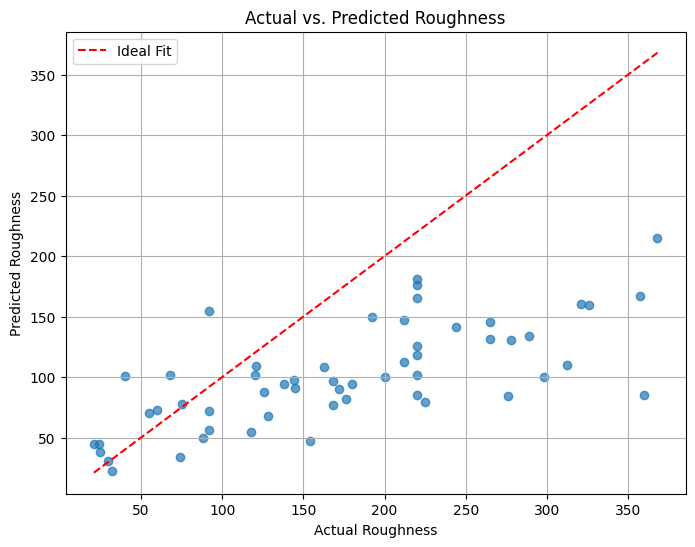

In [14]:
# Visualization: Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(data["roughness"], data["Predicted_roughness"], alpha=0.7)
plt.plot([data["roughness"].min(), data["roughness"].max()],
         [data["roughness"].min(), data["roughness"].max()], 'r--', label='Ideal Fit')
plt.title("Actual vs. Predicted Roughness")
plt.xlabel("Actual Roughness")
plt.ylabel("Predicted Roughness")
plt.legend()
plt.grid()
plt.show()

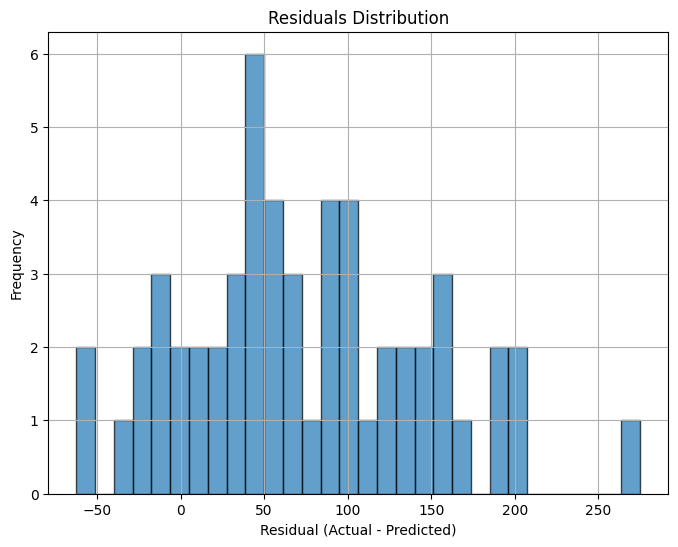

In [15]:
# Visualization: Residuals Histogram
plt.figure(figsize=(8, 6))
residuals = data["roughness"] - data["Predicted_roughness"]
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='k')
plt.title("Residuals Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid()
plt.show()